In [ ]:
%pip install transformers
%pip install PyPDF2
%pip install pycryptodome
%pip install pdfminer.six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.2 MB/s eta 0:00:00


In [ ]:
%pip show pycryptodome

Name: pycryptodome
Version: 3.19.0
Summary: Cryptographic library for Python
Home-page: https://www.pycryptodome.org
Author: Helder Eijs
Author-email: helderijs@gmail.com
License: BSD, Public Domain
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import os
import re
import numpy as np
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
import PyPDF2
from Crypto.Cipher import AES
from pdfminer.high_level import extract_text

Granting Google Drive Access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extract Text From PDF

In [ ]:
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        if reader.is_encrypted:
            print(f"PDF {pdf_path} is encrypted!")
            return None
        for page in reader.pages:
            text += page.extract_text()
    return text

folder_path = "/content/drive/Shareddrives/AHB Product Dev./PRisk.ai/SCR"

scr_texts = []
for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        pdf_path = os.path.join(folder_path, filename)
        scr_texts.append(extract_text_from_pdf(pdf_path))


PDF /content/drive/MyDrive/PRisk.ai/SCR/david_serious_case_review_-_april_2021.pdf is encrypted!


Auto-synthetic Labelling

In [ ]:
all_sentences = []
for text in scr_texts:
    if text is None:
      print("Replace None with an empty string.")
      text = ""
    sentences = sent_tokenize(text)
    all_sentences.extend(sentences)

high_risk_keywords = ["abuse", "hurt", "injury", "danger", "violence", "neglect", "severe",
                      "serious harm", "Parental substance abuse", "alcohol", "new partner", "remarried",
                      "amphetamine", "drugs", "bruise", "assaulted", "Domestic Violence",
                      "Parental mental health problems","Parental unemployment", "Parental homelessness",
                      "Family history of child abuse or neglect", "Child is isolated from family and friends",
                      "Child is living in poverty","Child is exposed to violence or drugs in the community"]

medium_risk_keywords = ["warning", "concern", "alert", "potential harm", "risk", "caution",
                        "suspicion", "house moves", "migration","malnourished", "weight loss",
                        "bad odour", "school moves","Parental stress","Parental financial difficulties",
                        "Parental lack of social support","Child is experiencing academic difficulties",
                        "Child is experiencing behavioral problems","Child is frequently absent from school",
                        "Child is frequently moving homes","Child is living in a dangerous neighborhood"]


def assign_sentence_label(sentence):
    for keyword in high_risk_keywords:
        if keyword in sentence.lower():
            return 2  # High risk
    for keyword in medium_risk_keywords:
        if keyword in sentence.lower():
            return 1  # Medium risk
    return 0  # Low risk

sentence_labels = [assign_sentence_label(sent) for sent in all_sentences]

Replace None with an empty string.
Replace None with an empty string.


Import BERT Transformer and Obtain Embeddings

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings_for_sentences(sentences, batch_size=8):
    cls_embeddings = []
    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            embeddings = model(**inputs).last_hidden_state
        # Append the embedding of the [CLS] token for each sentence in the batch
        cls_embeddings.extend(embeddings[:, 0, :].cpu().numpy())
    return cls_embeddings

sentence_embeddings = get_bert_embeddings_for_sentences(all_sentences)

Recurrent Neural Network (RNN) Modelling

In [ ]:
import tensorflow as tf
import numpy as np

X_train, X_val, y_train, y_val = train_test_split(sentence_embeddings, sentence_labels, test_size=0.2, random_state=42)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

sentence_labels = np.array(sentence_labels)

# Define the RNN model for sentence-level classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(768,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes: Low, Medium, High risk
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 106883 (417.51 KB)
Trainable params: 106883 (417.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Training



In [ ]:
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/best_model.h5", save_best_only=True)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile the model with the custom metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

ValueError: ignored

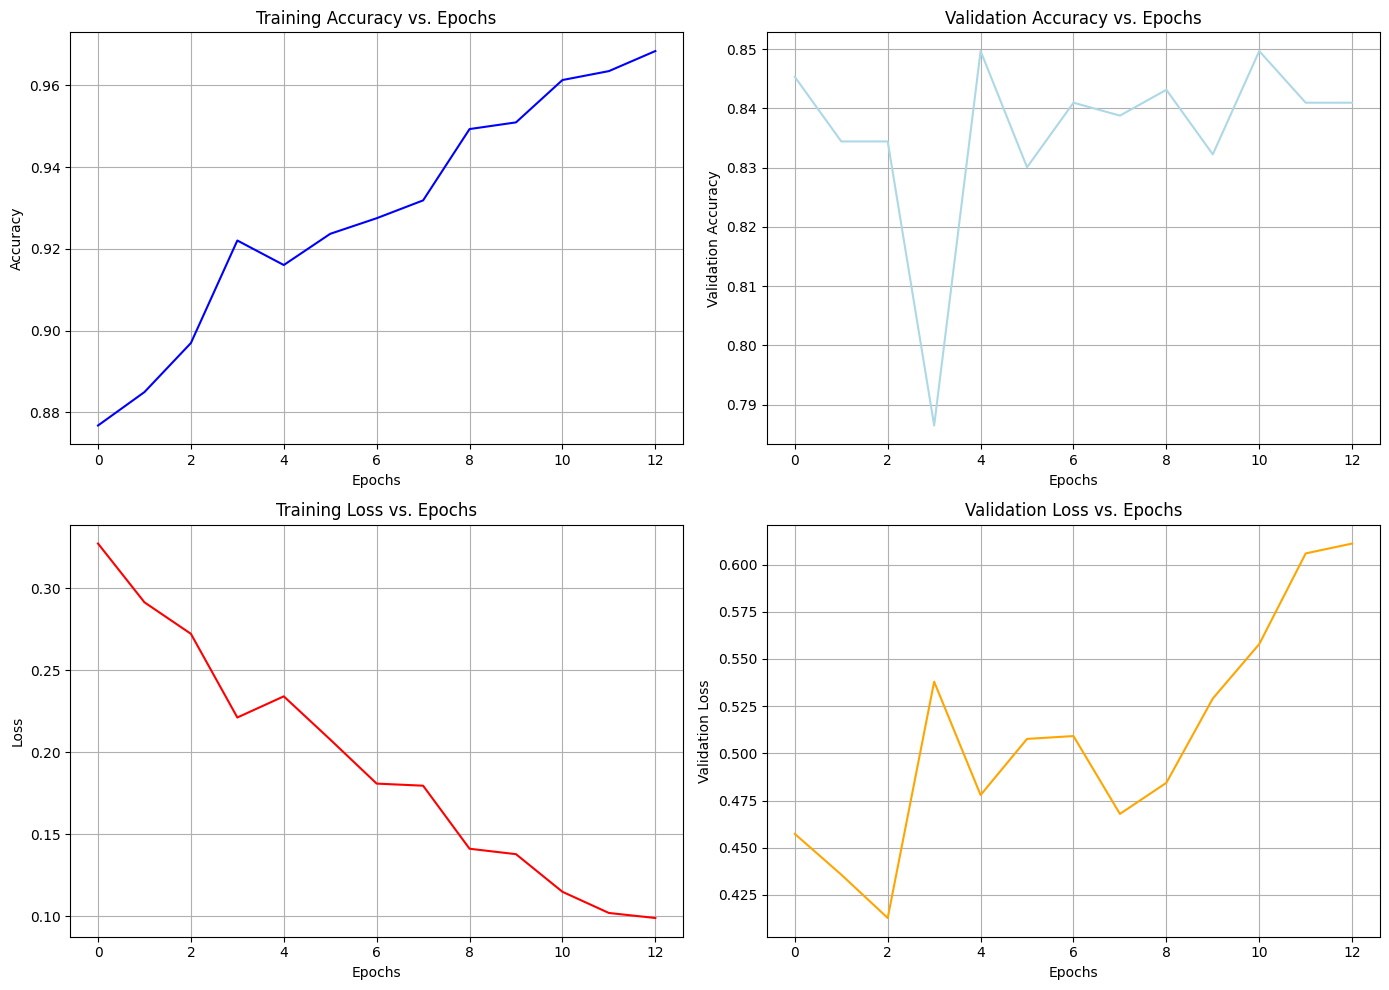

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

# Create individual line graphs for each metric
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot Training Accuracy
history_df['accuracy'].plot(ax=axes[0,0], color='blue', title="Training Accuracy vs. Epochs")
axes[0,0].set_ylabel("Accuracy")
axes[0,0].set_xlabel("Epochs")
axes[0,0].grid(True)

# Plot Validation Accuracy
history_df['val_accuracy'].plot(ax=axes[0,1], color='lightblue', title="Validation Accuracy vs. Epochs")
axes[0,1].set_ylabel("Validation Accuracy")
axes[0,1].set_xlabel("Epochs")
axes[0,1].grid(True)

# Plot Training Loss
history_df['loss'].plot(ax=axes[1,0], color='red', title="Training Loss vs. Epochs")
axes[1,0].set_ylabel("Loss")
axes[1,0].set_xlabel("Epochs")
axes[1,0].grid(True)

# Plot Validation Loss
history_df['val_loss'].plot(ax=axes[1,1], color='orange', title="Validation Loss vs. Epochs")
axes[1,1].set_ylabel("Validation Loss")
axes[1,1].set_xlabel("Epochs")
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

# Display the DataFrame
history_df


,loss,accuracy,f1_m,precision_m,recall_m,val_loss,val_accuracy,val_f1_m,val_precision_m,val_recall_m
0,0.327389,0.876772,0.444957,0.280477,1.155501,0.457317,0.845316,0.422222,0.259773,1.178016
1,0.291533,0.884951,0.425314,0.267471,1.120307,0.435749,0.834423,0.426456,0.261617,1.205423
2,0.272314,0.896947,0.433243,0.274821,1.122045,0.412787,0.834423,0.404385,0.248508,1.142804
3,0.221255,0.922028,0.421981,0.267752,1.101007,0.537937,0.786492,0.384885,0.238470,1.042698
4,0.234163,0.916031,0.418064,0.263713,1.111652,0.477916,0.849673,0.408497,0.250826,1.153042
5,0.207800,0.923664,0.411839,0.257867,1.110080,0.507638,0.830065,0.392929,0.240931,1.115661
6,0.180918,0.927481,0.420391,0.263662,1.121713,0.509146,0.840959,0.406869,0.248952,1.166772
7,0.179642,0.931843,0.400588,0.252437,1.068599,0.467920,0.838780,0.368126,0.226232,1.035106
8,0.141168,0.949291,0.400007,0.251569,1.078657,0.484390,0.843137,0.389384,0.237976,1.122857
9,0.137860,0.950927,0.403643,0.252497,1.074973,0.529027,0.832244,0.382351,0.234109,1.089153


Model Evaluation

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_f1, val_precision, val_recall = model.evaluate(X_val, y_val, verbose=0)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")

Validation Loss: 0.4128
Validation Accuracy: 0.8344
Validation F1 Score: 0.4044
Validation Precision: 0.2485
Validation Recall: 1.1428


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the validation set
y_pred = model.predict([X_val_ids, X_val_attention_mask])

# Convert y_pred to class labels if it's one-hot encoded
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_val_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: ignored

Save the Model

In [ ]:
# Save the model for deployment
model.save("/content/drive/Shareddrives/AHB Product Dev./PRisk.ai/priskai_rnn_model_v2.h5")
print("Model saved successfully!")

Model saved successfully!


Inferencing

In [ ]:
new_text = "Was there any instances that Daniel was observed with physical injuries?"
encoded_text = tokenizer.encode_plus(
    new_text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=512,  # Max length to truncate/pad
    return_attention_mask=True,  # Construct attention masks
    return_tensors='tf',  # Return as TensorFlow tensors
    truncation=True,  # Explicitly truncate to max length
    padding='max_length'  # Pad to max length
)
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']


Load the Model

In [ ]:
from keras.models import load_model

# Define the custom metrics functions
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Load the model
model = load_model("/content/drive/Shareddrives/AHB Product Dev./PRisk.ai/priskai_rnn_model_v2.h5",
                   custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})



Predict

In [ ]:
# Pad input_ids to shape (None, 768)
padded_input_ids = np.pad(input_ids, ((0,0),(0,256)), mode='constant')

# Predict using the padded input_ids
prediction = model.predict(padded_input_ids)

# Get the predicted class
predicted_class = np.argmax(prediction)

# Map the predicted class to its label
risk_labels = {0: "Low Risk", 1: "Medium Risk", 2: "High Risk"}
print(f"Predicted Risk: {risk_labels[predicted_class]}")






1/1 [==============================] - 0s 32ms/step
Predicted Risk: High Risk
